<a href="https://colab.research.google.com/github/ni-sha-c/GDEExpts/blob/main/regression_gde.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# If you have installed dgl-cuXX package, please uninstall it first.
!pip install  dgl -f https://data.dgl.ai/wheels/cu118/repo.html
!pip install  dglgo -f https://data.dgl.ai/wheels-test/repo.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.dgl.ai/wheels/cu118/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.4/86.4 MB 11.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.dgl.ai/wheels-test/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.1/112.1 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 63.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install torchdiffeq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import math
import numpy as np
import scipy.sparse as sp
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module

In [ ]:
import dgl
import dgl.data
import networkx as nx

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


# Helper Function

In [ ]:
from typing import Callable
import dgl.function as fn

class GCNLayer(nn.Module):
    def __init__(self, g:dgl.DGLGraph, in_feats:int, out_feats:int, activation:Callable[[torch.Tensor], torch.Tensor],
                 dropout:int, bias:bool=True):
        super().__init__()
        self.g = g
        self.weight = nn.Parameter(torch.Tensor(in_feats, out_feats))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(out_feats))
        else:
            self.bias = None
        self.activation = activation
        if dropout:
            self.dropout = nn.Dropout(p=dropout)
        else:
            self.dropout = 0.
        
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, h):
        # h here is x from m(x)
        # initialize h
        if self.dropout:
            h = self.dropout(h)

        h = torch.mm(h, self.weight)

        # normalization by square root of src degree
        h = h * self.g.ndata['norm']
        self.g.ndata['h'] = h
        # prev_timestep = self.g.ndata['feat'].reshape(2,1)
        original_h = h
        #print("initial h ", h)
        #print("prev_h", prev_h)

        # message passing and aggregation 
        # copy_u(): 'm' is the output message field and 'h' is the source feature field
        self.g.update_all(fn.copy_u('h', 'm'),
                          fn.mean(msg='m', out='h'))
        h = self.g.ndata.pop('h')

        # Should original data be included? but in which way?
        #h = h + (original_h* 0.5)
        # (self.g.ndata['feat']*0.3)
        #print("before ", h)
        # h = h + (prev_timestep* 0.1)
        #print("after ", h)
        #print("message passed h ", h)
        
        # normalization by square root of dst degree
        h = h * self.g.ndata['norm']
        
        # bias
        if self.bias is not None:
            h = h + self.bias
        if self.activation:
            h = self.activation(h)
        return h


class GCN(nn.Module):
    def __init__(self, num_layers:int, g:dgl.DGLGraph, in_feats:int, hidden_feats:int,
                 out_feats:int, activation:Callable, dropout:int, bias=True):
        super().__init__()
        self.layers = nn.ModuleList()

        self.layers.append(GCNLayer(g, in_feats, hidden_feats, activation, dropout))

        for i in range(num_layers - 2):
            self.layers.append(GCNLayer(g, hidden_feats, hidden_feats, activation, dropout))

        self.layers.append(GCNLayer(g, hidden_feats, out_feats, None, 0.))

    def set_graph(self, g):
        for l in self.layers:
            l.g = g

    def forward(self, features):
        h = features
        for layer in self.layers:
            h = layer(h)
        return h


In [ ]:
class GDEFunc(nn.Module):
    def __init__(self, gnn:nn.Module):
        """General GDE function class. To be passed to an ODEBlock"""
        super().__init__()
        self.gnn = gnn
        self.nfe = 0
    
    def set_graph(self, g:dgl.DGLGraph):
        for layer in self.gnn:
            layer.g = g
            
    def forward(self, t, x):
        self.nfe += 1
        x = self.gnn(x)
        return x

    
class ControlledGDEFunc(GDEFunc):
    def __init__(self, gnn:nn.Module):
        """ Controlled GDE version. Input information is preserved longer via hooks to input node features X_0, 
            affecting all ODE function steps. Requires assignment of '.h0' before calling .forward"""
        super().__init__(gnn)
        self.nfe = 0
            
    def forward(self, t, x):
        self.nfe += 1
        x = torch.cat([x, self.h0], 1)
        x = self.gnn(x)
        return x

In [ ]:
import torch.nn as nn
import torchdiffeq

class ODEBlock(nn.Module):
    def __init__(self, odefunc:nn.Module, method:str='dopri5', rtol:float=1e-4, atol:float=1e-4, adjoint:bool=True):
        """ Standard ODEBlock class. Can handle all types of ODE functions
            :method:str = {'euler', 'rk4', 'dopri5', 'adams'}
        """
        super().__init__()
        self.odefunc = odefunc
        self.method = method
        self.adjoint_flag = adjoint
        self.atol, self.rtol = atol, rtol

    def forward(self, x:torch.Tensor, T:int=1):
        #self.integration_time = torch.tensor([0, 0.1, 0.2, 0.25, 0.5, 0.6, 0.7, 0.75, T]).float()
        time = np.linspace(0, 0.5, 2)
        self.integration_time = torch.tensor(time).float()
        self.integration_time = self.integration_time.type_as(x)

        if self.adjoint_flag:
            out = torchdiffeq.odeint_adjoint(self.odefunc, x, self.integration_time,
                                             rtol=self.rtol, atol=self.atol, method=self.method)
        else:
            out = torchdiffeq.odeint(self.odefunc, x, self.integration_time,
                                     rtol=self.rtol, atol=self.atol, method=self.method)
        #print("out: ", out[0], out[250], out[-1])
        return out[-1]
    
    def forward_batched(self, x:torch.Tensor, nn:int, indices:list, timestamps:set):
        """ Modified forward for ODE batches with different integration times """
        timestamps = torch.Tensor(list(timestamps))
        if self.adjoint_flag:
            out = torchdiffeq.odeint_adjoint(self.odefunc, x, timestamps,
                                             rtol=self.rtol, atol=self.atol, method=self.method)
        else:
            out = torchdiffeq.odeint(self.odefunc, x, timestamps,
                                     rtol=self.rtol, atol=self.atol, method=self.method)

        out = self._build_batch(out, nn, indices).reshape(x.shape)
        return out
    
    def _build_batch(self, odeout, nn, indices):
        b_out = []
        for i in range(len(indices)):
            b_out.append(odeout[indices[i],i*nn:(i+1)*nn])
        return torch.cat(b_out).to(odeout.device)
              
        
    def trajectory(self, x:torch.Tensor, T:int, num_points:int):
        self.integration_time = torch.linspace(0, t_end, num_points)
        self.integration_time = self.integration_time.type_as(x)
        out = torchdiffeq.odeint(self.odefunc, x, self.integration_time,
                                 rtol=self.rtol, atol=self.atol, method=self.method)
        return out

In [ ]:
class PerformanceContainer(object):
    """ Simple data class for metrics logging."""
    def __init__(self, data:dict):
        self.data = data
        
    @staticmethod
    def deep_update(x, y):
        for key in y.keys():
            x.update({key: list(x[key] + y[key])})
        return x

def accuracy(y_hat:torch.Tensor, y:torch.Tensor):
    """ Standard percentage accuracy computation """
    preds = torch.max(y_hat, 1)[1]
    return torch.mean((y == preds).float())

# Semi-supervised node regression 

## Data preparation

**Our Data** \\
`X dim: num_node x num_feats (=1)` \\
`Y dim: num_node x dim (=1)`

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt
import random

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# seed for repeatability
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

torch.manual_seed(42)
np.random.seed(42)

In [ ]:
def deriv(t, X, a, b):
    """Return the derivatives dx/dt and dy/dt."""
    x, y = X
    dxdt = a - (1+b)*x + x**2 * y
    dydt = b*x - x**2 * y
    return dxdt, dydt

In [ ]:
# Generate data
# time iteration
ti, tf = 0, 500
t_eval = np.linspace(0, 500, 1001)

# initialize
a = 1
b = 2.02

In [ ]:
# Integrate Brusselator eq for parameters a, b
# solve_ivp: integrates a system of ODE given an initial value
#            (ti, tf) = interval of integration
#            (x0, y0) = initial state
#            dense_output = whether to compute a continuous solution 

# Step 2: Calculate ode for each interaction

ode = solve_ivp(deriv, (ti, tf), (1, 3), dense_output = True, args=(a,b), t_eval = t_eval)
sol = ode.y
print(len(sol[0]))

1001


In [ ]:
print(sol[0, :5])
print(sol[1, :5])

[1.         1.80456657 2.23344321 1.70875302 1.24250285]
[3.         2.02145081 1.01597082 1.04731267 1.28161112]


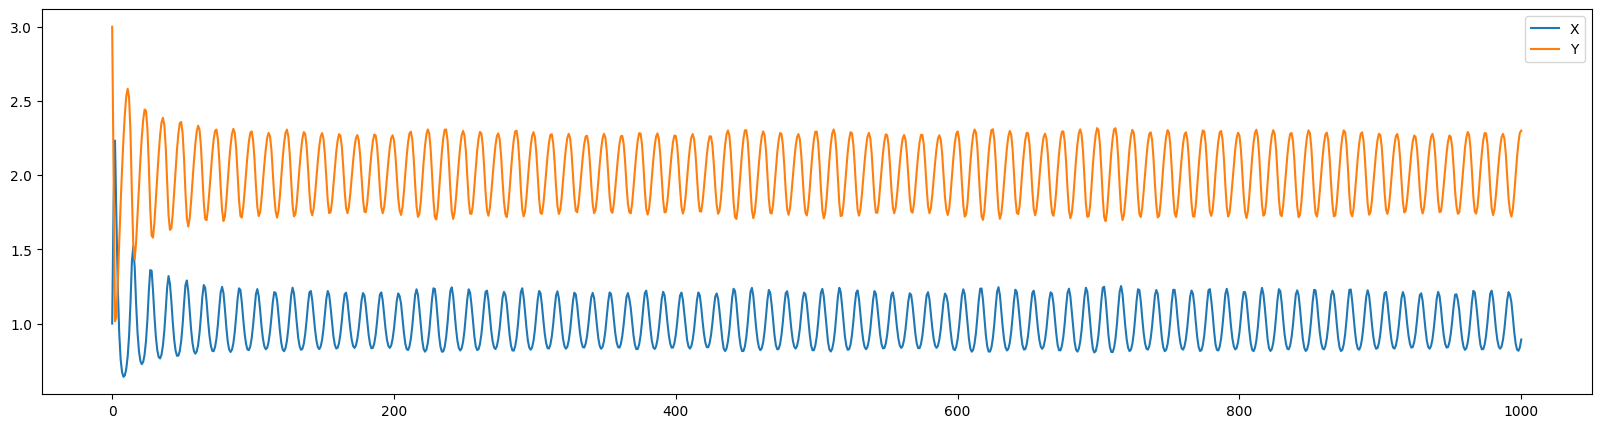

In [ ]:
# sanity check for generated brusellator dataset
plt.figure(figsize=(20,5))
plt.plot(sol[0], label="X")
plt.plot(sol[1], label="Y")
plt.legend()

In [ ]:
# Sanity Check
def brusselator(t, X):
    """Return the derivatives dx/dt and dy/dt."""
    x, y = X
    a = 1
    b = 2.02
    dxdt = a - (1+b)*x + x**2 * y
    dydt = b*x - x**2 * y
    return torch.tensor([dxdt, dydt])

init = torch.Tensor([1, 3])
t_eval_point = torch.linspace(ti, tf, 1001)
res = torchdiffeq.odeint(brusselator, init, t_eval_point) 

In [ ]:
# Step 3: Create one graph instance 

entire_rate = []
entire_y = []
n_train = 100
n_test = 48
n_nodes = 2
n_trans = 200

u = torch.tensor([0])
v = torch.tensor([1])

g = dgl.graph((u, v), num_nodes=2)

g.ndata["feat"] = res[n_trans-1]
g.ndata["label"] = res[n_trans-1]

'''Create Training Dataset'''
X = np.zeros((n_train, n_nodes))
Y = np.zeros((n_train, n_nodes))

for i in range(n_train):
  X[i] = res[n_trans+i]
  Y[i] = res[n_trans+1+i]

# convert array into dataframe
# DF_X = pd.DataFrame(X)
# DF_Y = pd.DataFrame(Y)

# save the dataframe as a csv file
# DF_X.to_csv("x.csv")
# DF_Y.to_csv("y.csv")

X = torch.tensor(X).reshape(n_train,2)
Y = torch.tensor(Y).reshape(n_train,2)

'''Create Test Dataset'''
X_test = np.zeros((n_test, n_nodes))
Y_test = np.zeros((n_test, n_nodes))

for i in range(n_test):
  X_test[i] = res[n_trans+n_train+i]
  Y_test[i] = res[n_trans+1+n_train+i]

X_test = torch.tensor(X_test).reshape(n_test, 2)
Y_test = torch.tensor(Y_test).reshape(n_test, 2)

In [ ]:
# sanity check training dataset creation
print("scipy odesolver: ", sol[:, 200:205], "\n")
print("torchdiffeq :", res[200:], "\n")
print(X[:5])
print(Y[:5])

scipy odesolver:  [[0.9663205  1.05984426 1.15546462 1.20274259 1.18443156]
 [2.2351103  2.13540661 1.98447185 1.84407494 1.76209123]] 

torchdiffeq : tensor([[0.9198, 2.2531],
        [0.9959, 2.1990],
        [1.0874, 2.0868],
        ...,
        [1.1223, 1.7807],
        [1.0405, 1.8213],
        [0.9599, 1.9023]]) 

tensor([[0.9198, 2.2531],
        [0.9959, 2.1990],
        [1.0874, 2.0868],
        [1.1671, 1.9422],
        [1.1966, 1.8191]], dtype=torch.float64)
tensor([[0.9959, 2.1990],
        [1.0874, 2.0868],
        [1.1671, 1.9422],
        [1.1966, 1.8191],
        [1.1598, 1.7642]], dtype=torch.float64)


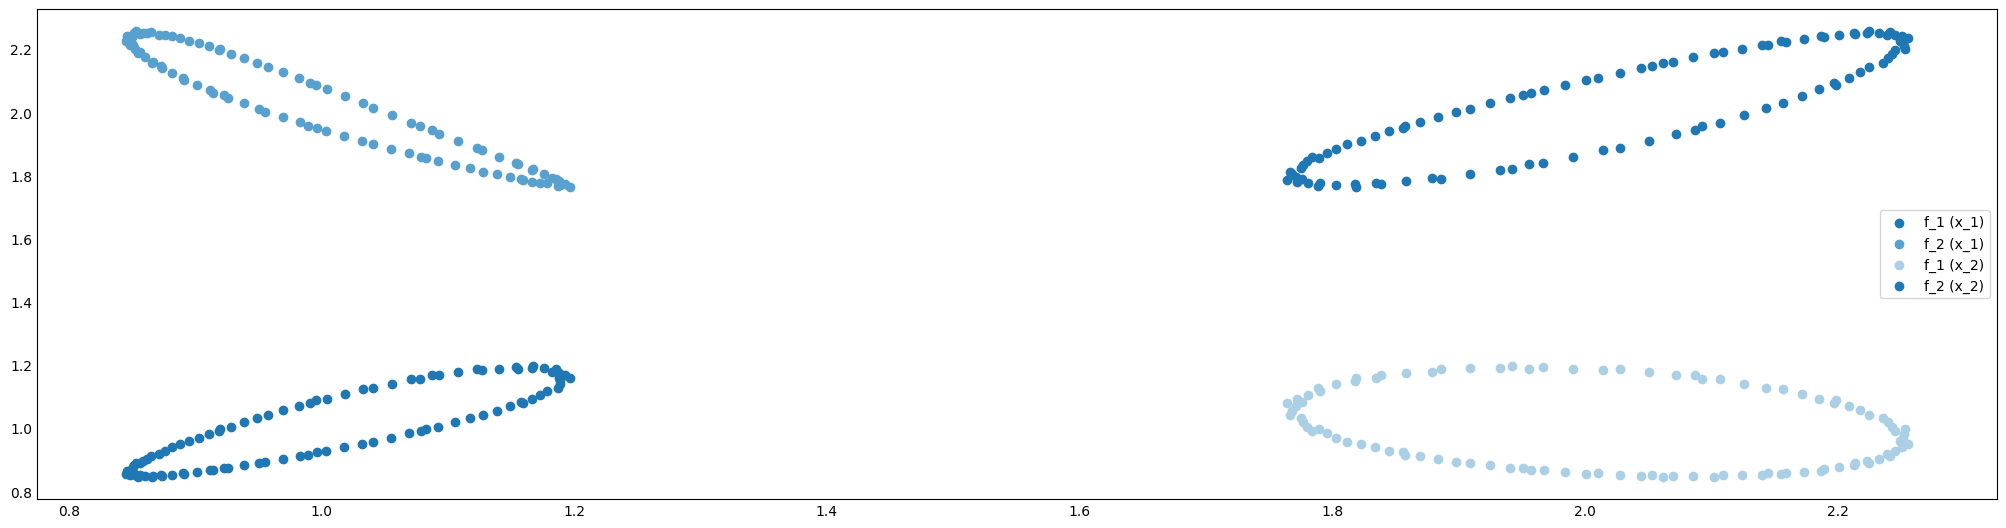

In [ ]:
# sanity check
plt.figure(figsize=(20,5))

x = list(range(0,15))
#plt.plot(x, X_test[0:15, 0], label="X")
#plt.plot(x, Y_test[0:15, 0], label="Y")


# Phase Portrait (Space)
plt.scatter(X[:,0], Y[:,0], label="f_1 (x_1)")
plt.scatter(X[:,0], Y[:,1], label="f_2 (x_1)")
plt.scatter(X[:,1], Y[:,0], label="f_1 (x_2)")
plt.scatter(X[:,1], Y[:,1], label="f_2 (x_2)")

plt.xticks()
plt.grid()
plt.legend()

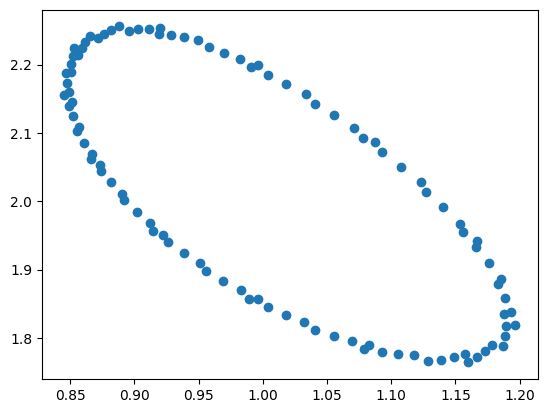

In [ ]:
plt.scatter(X[:, 0], X[:,1])

**Modification** \\

`Before change: num_edges = 1` \\
`After change: num_edges = 2` \\

DGL graph is directed graph when our graph instances are undirected graph. Therefore, graph from previous attempt only had one edge, which made node feature 'norm' 0 for one node and 1 for the other node. But due to normalization process in GCN layer, node with 'norm' = 0 will always have 0 for hidden representation. Therefore, added one more edge so that 'norm' will become [1,1] instead of [0,1]

In [ ]:
#modification
g.add_edges(torch.tensor([1]), torch.tensor([0]))
#g.add_edges(g.nodes(), g.nodes())
g

Graph(num_nodes=2, num_edges=2,
      ndata_schemes={'feat': Scheme(shape=(), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.float32)}
      edata_schemes={})

In [ ]:
g.edges()

(tensor([0, 1]), tensor([1, 0]))

In [ ]:
X.shape, Y.shape, X_test.shape, Y_test.shape

(torch.Size([100, 2]),
 torch.Size([100, 2]),
 torch.Size([48, 2]),
 torch.Size([48, 2]))

In [ ]:
# compute diagonal of normalization matrix D according to standard formula
degs = g.in_degrees().float()
norm = torch.pow(degs, -0.5)
norm[torch.isinf(norm)] = 0
# add to dgl.Graph in order for the norm to be accessible at training time
g.ndata['norm'] = norm.unsqueeze(1).to(device)

# Graph Neural Differential Equations (GDEs)

As Neural ODEs, GDEs require specification of an ODE function (`ODEFunc`), representing the set of layers that will be called repeatedly by the ODE solver, as well as an ODE block (`ODEBlock`), tasked with calling the ODE solver on the ODE function. The ODEFunc is passed to the ODEBlock at initialization.

We introduce the convolutional variant of GDEs, `GCDEs`. The only difference resides in the type of GNN layer utilized in the ODEFunc.

For adaptive step GDEs (dopri5) we increase the hidden dimension to 64 to reduce the stiffness of the ODE and therefore the number of ODEFunc evaluations (`NFE`: Number Function Evaluation)

**modification** \\
Drop out was all set to 0 because our dataset is already small

In [ ]:
# for GCDEs, the ODEFunc is specified by two GCN layers. Softplus is used as activation. Smoother activations
# have been observed to help avoid numerical instability and reduce stiffness of the ODE described
# by a repeated call to the ODEFunc. High dropout improves performance on transductive node classification
# tasks due to their small training sets. GDEs can take advantage of this property due to their 'deeper'
# computational graph. NOTE: too much dropout increases stiffness and therefore NFEs
from dgl.nn import SAGEConv

torch.manual_seed(42)
num_feats = 5
out_feats = 1
hidden_dim = 5

#64
gnn = nn.Sequential(GCNLayer(g=g, in_feats=hidden_dim, out_feats=hidden_dim, activation=None, dropout=0.)
                    ).to(device)

# gnn = nn.Sequential(SAGEConv(hidden_dim, hidden_dim, 'mean'),
#                     SAGEConv(hidden_dim, hidden_dim, 'mean')).to(device)



gdefunc = GDEFunc(gnn)

# dopri5 is an adaptive step solver and will call `gdefunc` several times to ensure correctness up to pre-specified 
# tolerance levels. rk4 will call the func 4 times. As suggested in the original Neural ODE paper and as observed during internal tests, lower tolerances 
# are sufficient for classification tasks. 
gde = ODEBlock(odefunc=gdefunc, method='rk4', atol=1e-4, rtol=1e-4, adjoint=True).to(device)


m = nn.Sequential(GCNLayer(g=g, in_feats=num_feats, out_feats=hidden_dim, activation=None, dropout=0.),
                  gde,
                  GCNLayer(g=g, in_feats=hidden_dim, out_feats=out_feats, activation=None, dropout=0.)
                  ).to(device)

# m = nn.Sequential(gde).to(device)

In [ ]:
for mod in m.named_modules():
  print(mod)

### Training loop

In our current GDE model, ODEFunc is evaluated 480 times, it is considered as deep model rather than shallow network model.


**Modification** \\
`Before change: single for loop` \\
`After change: double for loop to iterate over one graph instance at a time` \\

This change is based on GDE paper, section 4.2 Multi–Agent Trajectory Extrapolation. On experiment setup, authors note that "all models are optimized to minimize mean–squared–error (MSE) of 1–step predictions using Adam (Kingma and Ba, 2014) with constant learning rate 0.01." 



Things I want to try:

1. **Since there's only one neighbor, make GCN layer to 1 not 2 => worked really well. After the same number of epoch, training loss and test loss was lower.**

2. Since it does not update itself, enforce self-loop by adding [1,1], [0,0] edges (so that it updates based on itself's info too along with neighborhood's info) -> does not work -> I think this is because we don't need this as we are already including oneself through ..?

Expression of learning dynamic came from GDE paper

Things I tried but did not work:
- making input dataset into weighted adjacency matrix. -> did not work very well.

**some observation**

1. For both Neural ODE, Static Model (2 Linear Layer), GDE, it first learns trend or dynamic (but not in correct timestep, lagged version), then in later epoch, it learns correct timestep.

2. For Static Model and Neural ODE, 1x2 input quickly learned correctly. but when given 2x1 data, it learned lagged version of dynamic system.
- Especially, 2x1 gradient quickly becomes 0 after 100 or 200 epoch. 
- When thinking about number of weights 2x1 model have compared to 1x2 model, half, I think 2x1 model is not complex enough to accurately learn the model. 

**Changes**
- from delta t = 1 -> changed to delta t = 0.5
- from generating data from scipy, changed to torchdiffeq, because there was some difference in the computed value. Just to make sure.

In [ ]:
# Dataloader
train_data = torch.utils.data.TensorDataset(X, Y)
test_data = torch.utils.data.TensorDataset(X_test, Y_test)

# Data iterables
train_iter = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=False)
test_iter = torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=False)

In [ ]:
# initial parameter
for param in m.named_parameters():
  print(param)

In [ ]:
for x,y in train_iter:
  print(x)
  print(y)
  print("---------")

# tensor([[0.9198, 2.2531],
#         [0.9959, 2.1990]], dtype=torch.float64)
# tensor([[0.9959, 2.1990],
#         [1.0874, 2.0868]], dtype=torch.float64)
# ---------
# tensor([[1.0874, 2.0868],
#         [1.1671, 1.9422]], dtype=torch.float64)
# tensor([[1.1671, 1.9422],
#         [1.1966, 1.8191]], dtype=torch.float64)

In [ ]:
for x,y in train_iter:
  print(x.T)
  print(y.T)

In [ ]:
def evaluate(model):
  pred_test = []
  true_test = []
  test_loss_all = []

  with torch.no_grad():
    model.eval()
    test_loss_sum = 0.0

    for x,y in test_iter:
      xk = x.T.to(device)
      yk = y.T.to(device)

      prev_timestep = g.ndata['feat'].reshape(2,1)
      x_concat = torch.cat((prev_timestep, xk), 1)

      # calculating outputs again with zeroed dropout
      y_pred_test = model(x_concat)

      # save predicted node feature for analysis
      pred_test.append(y_pred_test.detach().numpy())
      true_test.append(yk[:,-1].detach().numpy())
      g.ndata['feat'] = xk[:,-1]
      

    test_loss = criterion(y_pred_test, yk[:,-1].reshape(2,1)).item()
    print("test loss: ", test_loss)


  return pred_test, true_test, test_loss

In [ ]:
opt = torch.optim.Adam(m.parameters(), lr=1e-1, weight_decay=5e-4)
criterion = torch.nn.MSELoss()

steps = 2200 #100
num_grad_steps = 0

pred_train = []
true_train = []
x_train = []
pred_test = None
true_test = None

train_loss = 0

for i in range(steps): # looping over epochs
  train_loss_sum = 0.0
  m.train()
  m.double()

  y_pred = torch.zeros(len(train_iter), 2, 1)
  y_true = torch.zeros(len(train_iter), 2, 1)
  k = 0
  x_train = []
  
  for xk,yk in train_iter:
    # make input dim to num_of_node x num_of_feat
    xk = xk.T.to(device) 
    yk = yk.T.to(device)

    # create input x into [xk @ t-1, t, t+1 ... t+n] y into [yk @ t+(n+1)]
    prev_timestep = g.ndata['feat'].reshape(2,1)
    x = torch.cat((prev_timestep, xk), 1)

    start_time = time.time()
    y_pred[k] = m(x)
    y_true[k] = yk[:,-1].reshape(2,1)

    f_time = time.time() - start_time
    #nfe = m._modules['1'].odefunc.nfe
    g.ndata['feat'] = xk[:,-1]
    x_train.append(x[:,-1].detach().numpy())
    # save predicted node feature for analysis
    k += 1

  loss = criterion(y_pred, y_true)
  train_loss = loss.item()
  
  opt.zero_grad()
  start_time = time.time()
  loss.backward()
  b_time = time.time() - start_time
  opt.step()

  num_grad_steps += 1

  pred_train.append(y_pred.detach().numpy())
  true_train.append(y_true.detach().numpy())

  print(num_grad_steps, train_loss)

  # evaluate
  pred_test, true_test, test_loss = evaluate(m)

In [ ]:
pred_train = np.array(pred_train)
true_train = np.array(true_train)
pred_test = np.array(pred_test)
true_test = np.array(true_test)
x_train = np.array(x_train)
pred_train_last = pred_train[-1]
true_train_last = true_train[-1]

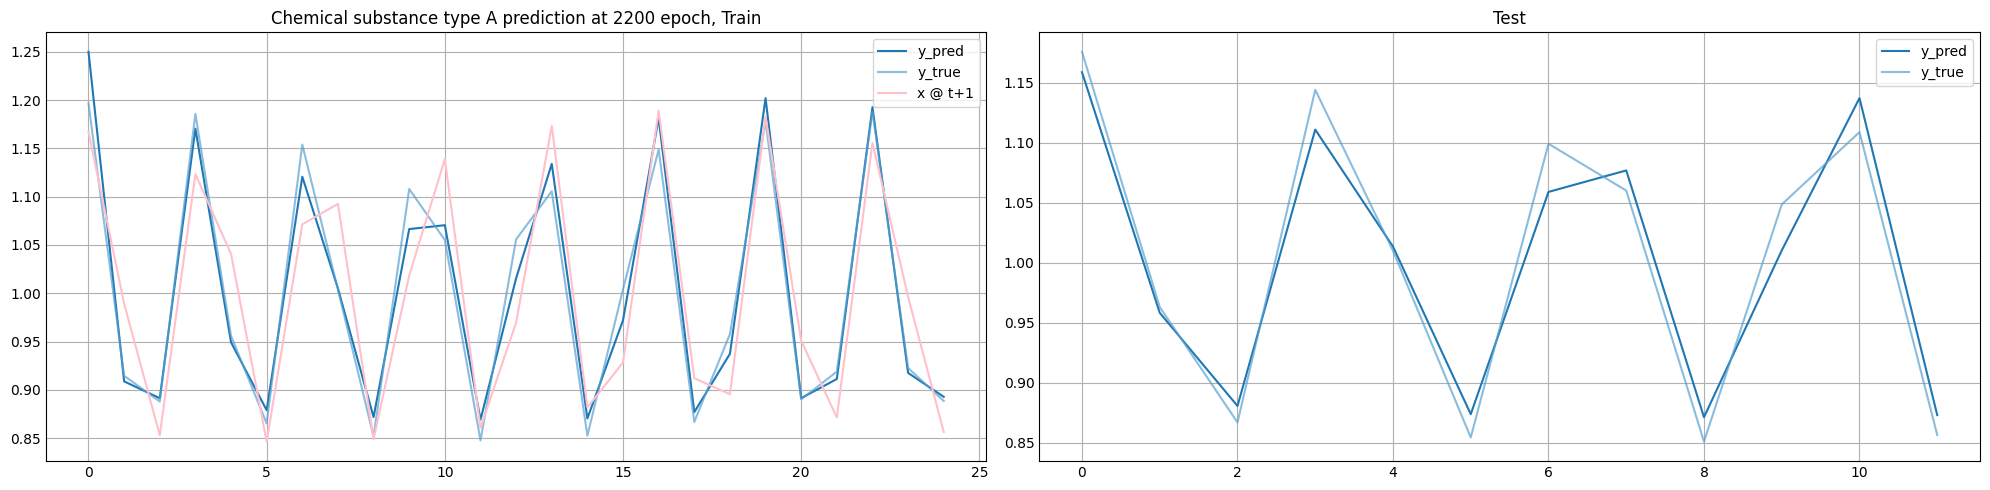

In [ ]:
plt.figure(figsize=(20,5))
plt.style.use('_mpl-gallery')

x = list(range(0,25))
x_test = list(range(len(test_iter)))

plt.subplot(1,2,1)
plt.plot(x, pred_train_last[:25, 0, 0])
plt.plot(x, true_train_last[:25, 0, 0], alpha=0.7)
# plt.plot(x, X[:50, 0], alpha=0.7, color='pink')
plt.plot(x, x_train[:25, 0], color='pink')
# plt.plot(x, X[:50, 1], alpha=0.7, color='black')
plt.legend(['y_pred', 'y_true', 'x @ t+1'])
plt.title('Chemical substance type A prediction at {} epoch, Train'.format(steps))
plt.xticks()

plt.subplot(1,2,2)
plt.plot(x_test, pred_test[:, 0])
plt.plot(x_test, true_test[:, 0], alpha=0.7)
plt.legend(['y_pred', 'y_true'])
plt.title('Test')

# plt.xticks(np.arange(0, 100, step=1))
plt.yticks()
plt.tight_layout()
plt.show()

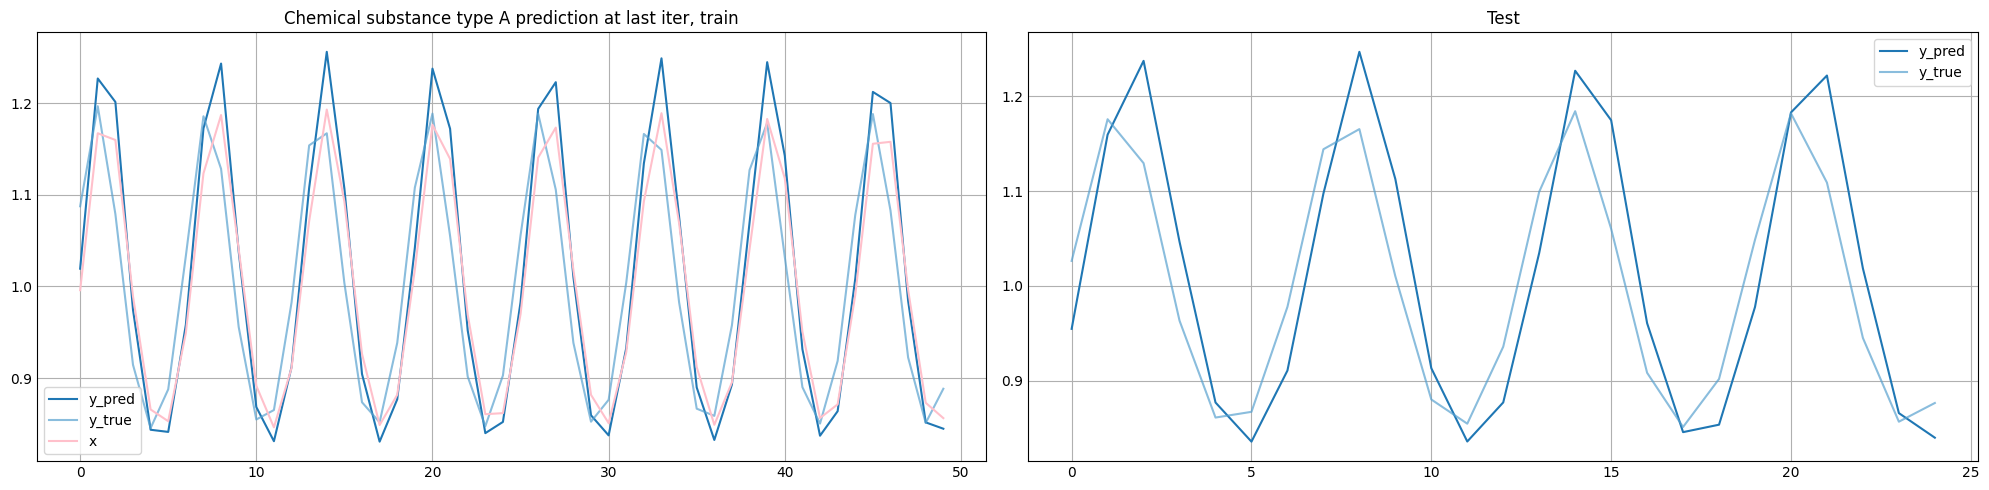

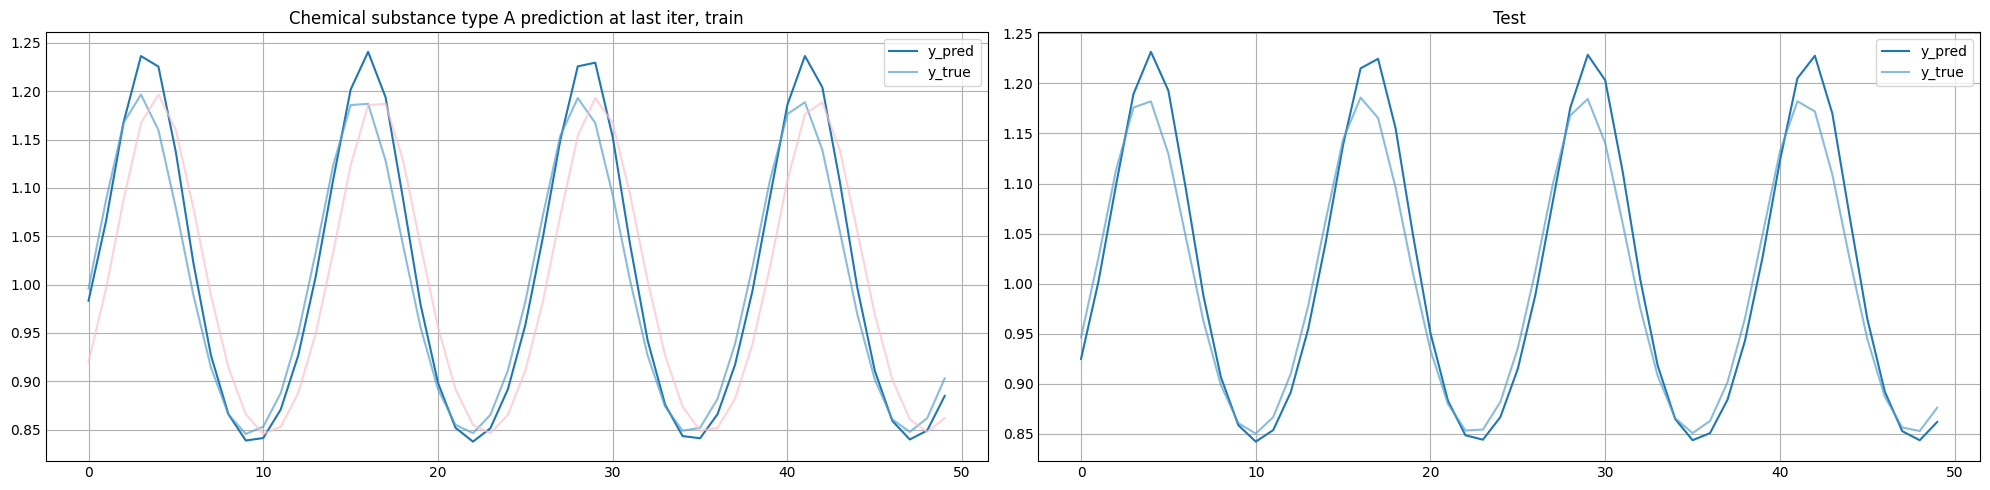

After about 700+500+700 iteration, training loss was 0.00133965 and test loss  0.0001106045. Input dimension was 2x2

## Past Result

### 1. Experiment with different training dataset size
hidden_dim = 1 \\
num of GCN layer in GDE = 2 \\
same param initialization with rand(42)

**1. 100**


```
Final Model with training dataset size of 100: 
Mean Squared Error of Training:  0.025339999999999998
Mean Squared Error of Test:  0.0245

('0.weight', Parameter containing:
tensor([[-0.5889]], dtype=torch.float64, requires_grad=True))
('0.bias', Parameter containing:
tensor([1.2123], dtype=torch.float64, requires_grad=True))
('1.odefunc.gnn.0.weight', Parameter containing:
tensor([[-0.8184]], dtype=torch.float64, requires_grad=True))
('1.odefunc.gnn.0.bias', Parameter containing:
tensor([1.4097], dtype=torch.float64, requires_grad=True))
('1.odefunc.gnn.1.weight', Parameter containing:
tensor([[-0.7476]], dtype=torch.float64, requires_grad=True))
('1.odefunc.gnn.1.bias', Parameter containing:
tensor([0.4852], dtype=torch.float64, requires_grad=True))
('2.weight', Parameter containing:
tensor([[-1.0852]], dtype=torch.float64, requires_grad=True))
('2.bias', Parameter containing:
tensor([1.0883], dtype=torch.float64, requires_grad=True))
```



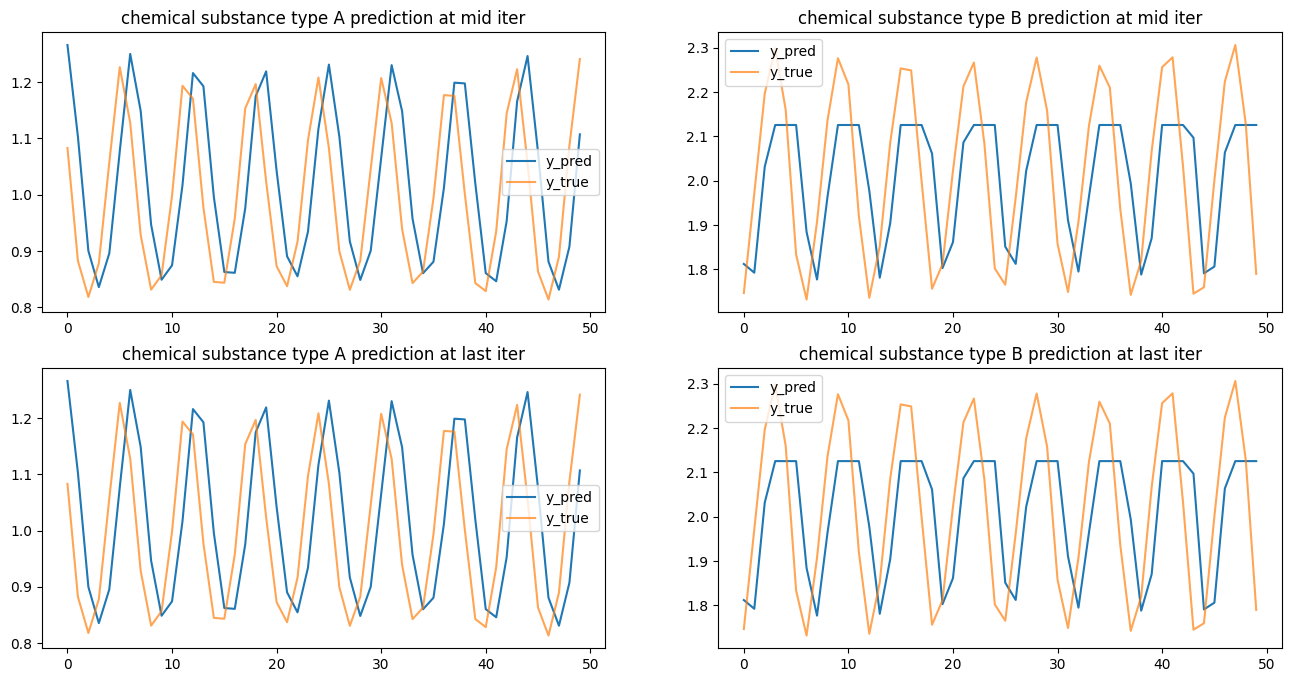

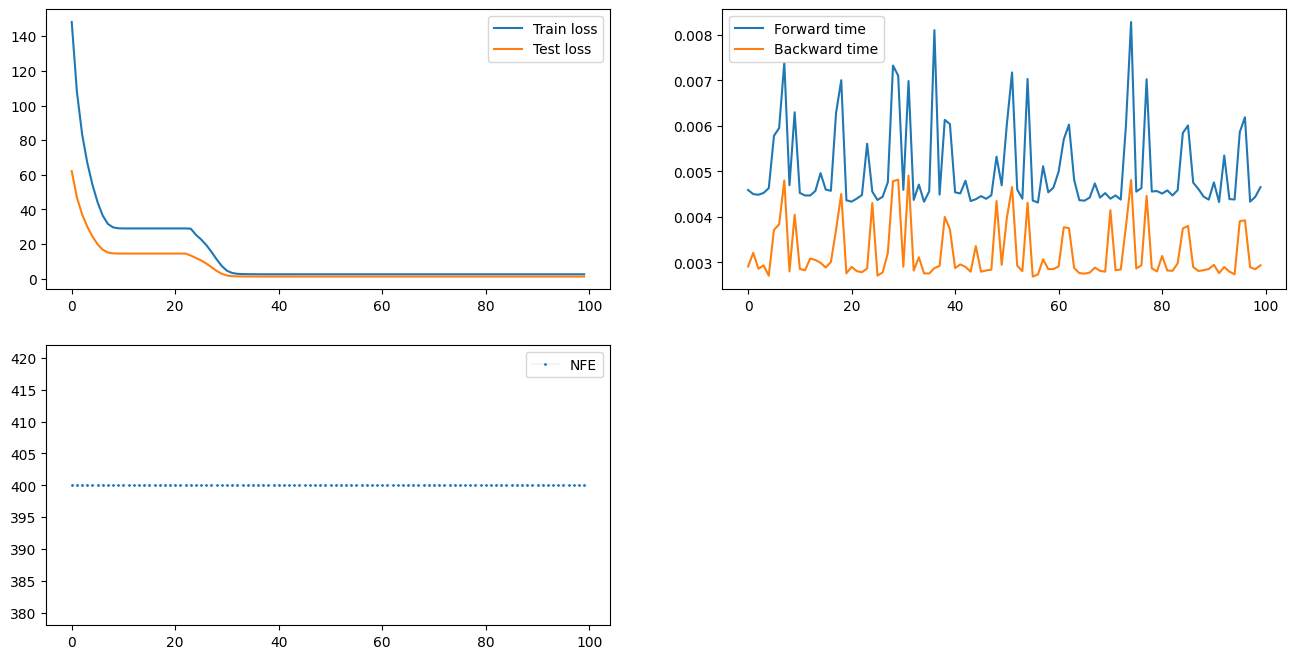


**2. 200**

```
Final Model with training dataset size of 200: 
Mean Squared Error of Training:  0.02561
Mean Squared Error of Test:  0.027280000000000002
```


```
('0.weight', Parameter containing:
tensor([[1.6248]], dtype=torch.float64, requires_grad=True))
('0.bias', Parameter containing:
tensor([-0.6224], dtype=torch.float64, requires_grad=True))
('1.odefunc.gnn.0.weight', Parameter containing:
tensor([[-0.5056]], dtype=torch.float64, requires_grad=True))
('1.odefunc.gnn.0.bias', Parameter containing:
tensor([0.3315], dtype=torch.float64, requires_grad=True))
('1.odefunc.gnn.1.weight', Parameter containing:
tensor([[-0.4778]], dtype=torch.float64, requires_grad=True))
('1.odefunc.gnn.1.bias', Parameter containing:
tensor([0.1083], dtype=torch.float64, requires_grad=True))
('2.weight', Parameter containing:
tensor([[0.5362]], dtype=torch.float64, requires_grad=True))
('2.bias', Parameter containing:
tensor([0.5925], dtype=torch.float64, requires_grad=True))
```



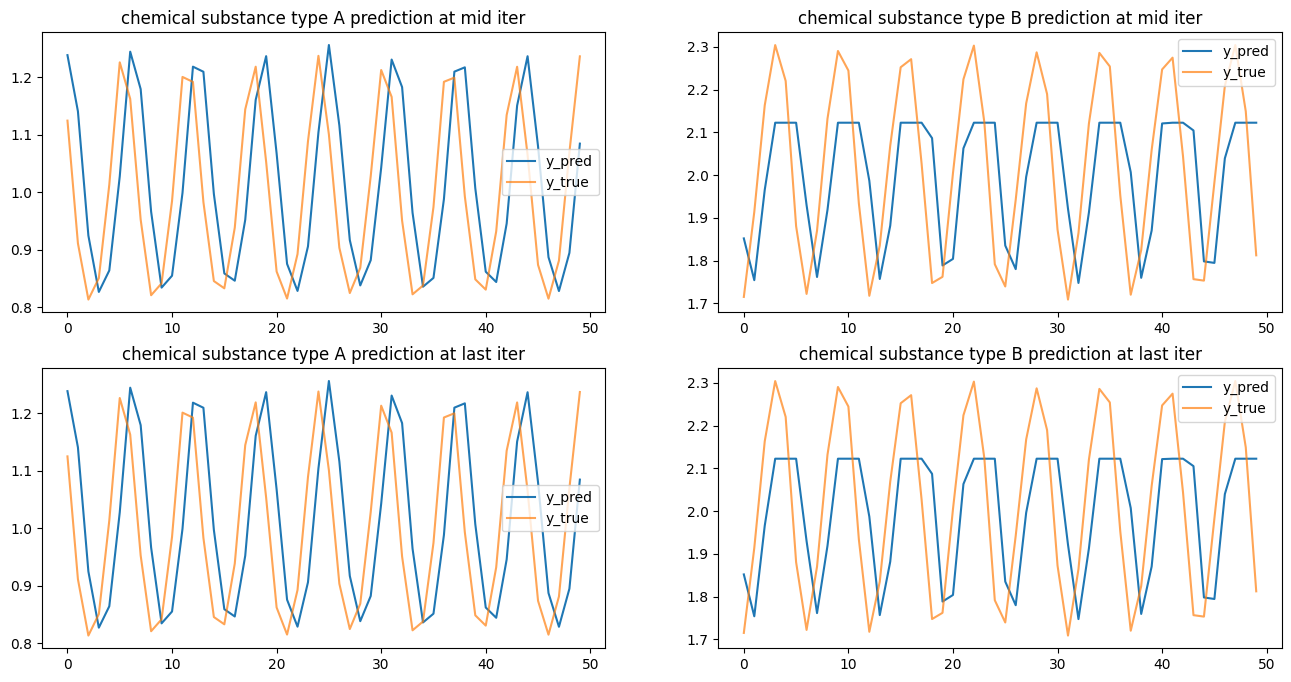

### 2. Number of GCN layer in GDE

**num of layer = 1** \\



```
Final Model with one GCN layer in GDE
Mean Squared Error of Training:  0.025339999999999998
Mean Squared Error of Test:  0.0245 

('0.weight', Parameter containing:
tensor([[-0.5889]], dtype=torch.float64, requires_grad=True))
('0.bias', Parameter containing:
tensor([1.2123], dtype=torch.float64, requires_grad=True))
('1.odefunc.gnn.0.weight', Parameter containing:
tensor([[-0.8184]], dtype=torch.float64, requires_grad=True))
('1.odefunc.gnn.0.bias', Parameter containing:
tensor([1.4097], dtype=torch.float64, requires_grad=True))
('1.odefunc.gnn.1.weight', Parameter containing:
tensor([[-0.7476]], dtype=torch.float64, requires_grad=True))
('1.odefunc.gnn.1.bias', Parameter containing:
tensor([0.4852], dtype=torch.float64, requires_grad=True))
('2.weight', Parameter containing:
tensor([[-1.0852]], dtype=torch.float64, requires_grad=True))
('2.bias', Parameter containing:
tensor([1.0883], dtype=torch.float64, requires_grad=True))
```

Initial Parameter with rand(42):
```
('0.weight', Parameter containing:
tensor([[-0.2343]], requires_grad=True))
('0.bias', Parameter containing:
tensor([0.9186], requires_grad=True))
('1.odefunc.gnn.0.weight', Parameter containing:
tensor([[0.7645]], requires_grad=True))
('1.odefunc.gnn.0.bias', Parameter containing:
tensor([0.8300], requires_grad=True))
('2.weight', Parameter containing:
tensor([[-0.2191]], requires_grad=True))
('2.bias', Parameter containing:
tensor([0.2018], requires_grad=True))
```

The resulting graph was very similar or almost looked the same with that of num of layer = 2. Takeaway is that although num of layer is decreased to 1, it still performed the same. 


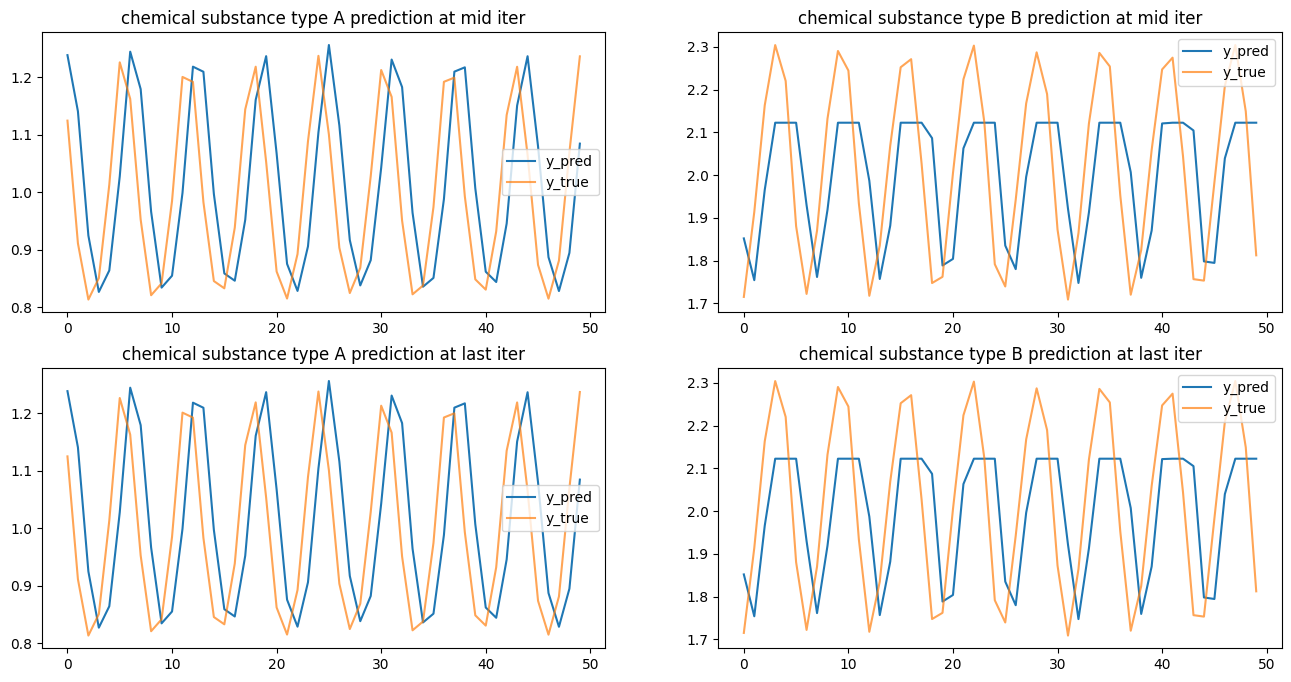

**num of layer = 3**



```
Final Model with three GCN layer in GDE
Mean Squared Error of Training:  0.027440000000000003
Mean Squared Error of Test:  0.0268 

('0.weight', Parameter containing:
tensor([[0.6967]], dtype=torch.float64, requires_grad=True))
('0.bias', Parameter containing:
tensor([0.5605], dtype=torch.float64, requires_grad=True))
('1.odefunc.gnn.0.weight', Parameter containing:
tensor([[-0.3302]], dtype=torch.float64, requires_grad=True))
('1.odefunc.gnn.0.bias', Parameter containing:
tensor([0.3163], dtype=torch.float64, requires_grad=True))
('1.odefunc.gnn.1.weight', Parameter containing:
tensor([[-0.2823]], dtype=torch.float64, requires_grad=True))
('1.odefunc.gnn.1.bias', Parameter containing:
tensor([0.7494], dtype=torch.float64, requires_grad=True))
('1.odefunc.gnn.2.weight', Parameter containing:
tensor([[-0.1846]], dtype=torch.float64, requires_grad=True))
('1.odefunc.gnn.2.bias', Parameter containing:
tensor([0.1993], dtype=torch.float64, requires_grad=True))
('2.weight', Parameter containing:
tensor([[1.3578]], dtype=torch.float64, requires_grad=True))
('2.bias', Parameter containing:
tensor([-0.6922], dtype=torch.float64, requires_grad=True))
```

Interesting thing: MSE slightly increased, but y_pred looked more correct when plotted out as graph! \\

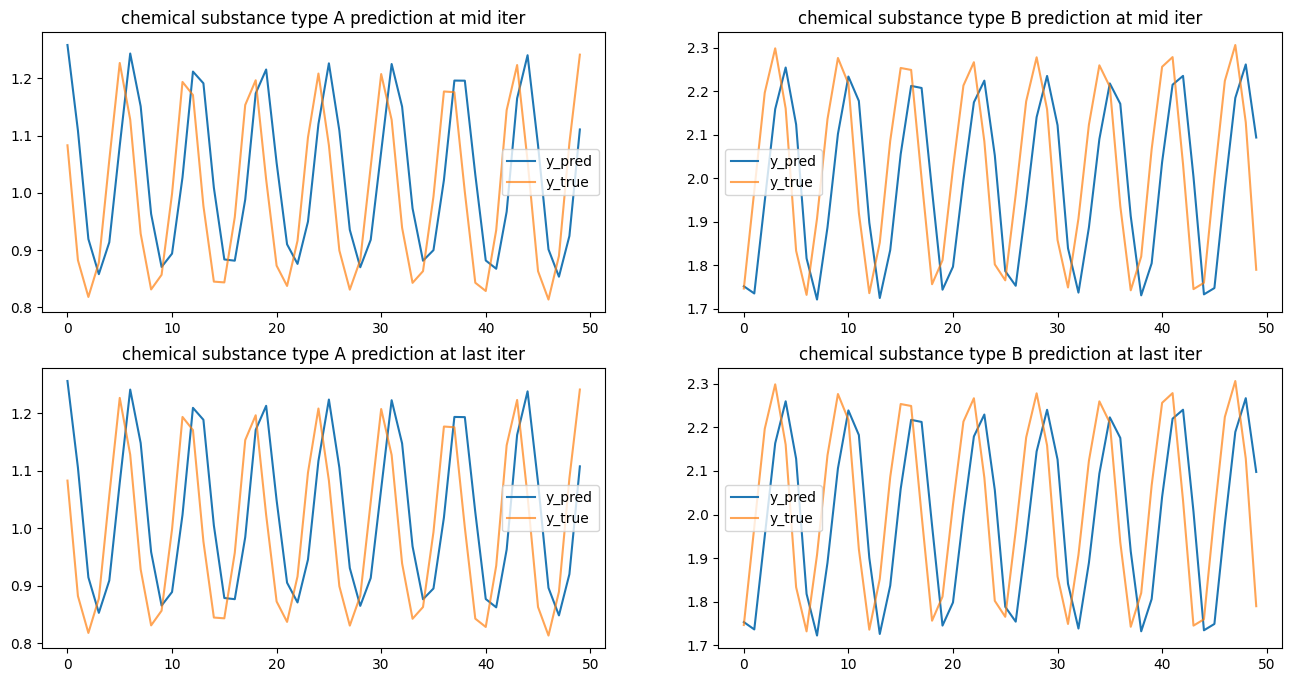




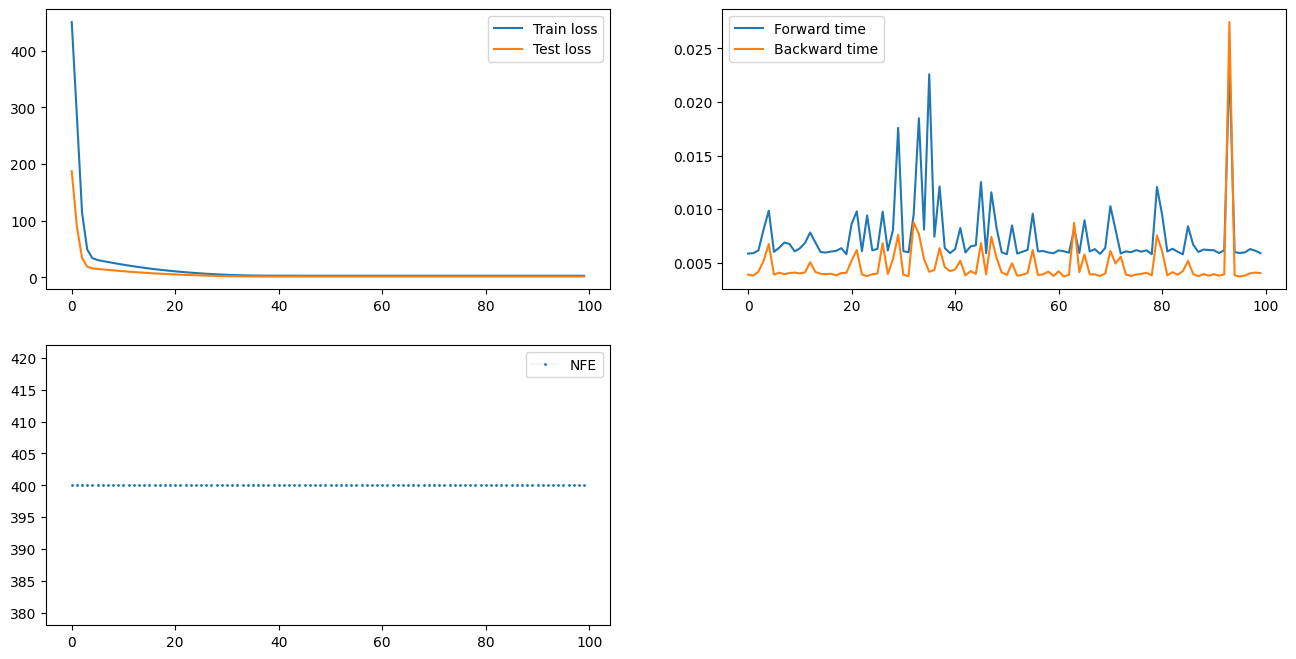

### Experiment with diff num of feature

num of GCN layer in GDE = 2 \\

**num = 2**


```
Final Model with hidden dim = 2
Mean Squared Error of Training:  0.027690000000000003
Mean Squared Error of Test:  0.026920000000000003 

('0.weight', Parameter containing:
tensor([[0.7085, 0.3209]], dtype=torch.float64, requires_grad=True))
('0.bias', Parameter containing:
tensor([ 0.2188, -0.2066], dtype=torch.float64, requires_grad=True))
('1.odefunc.gnn.0.weight', Parameter containing:
tensor([[ 0.2122,  0.6722],
        [-0.0140,  0.6246]], dtype=torch.float64, requires_grad=True))
('1.odefunc.gnn.0.bias', Parameter containing:
tensor([-0.0386,  0.0977], dtype=torch.float64, requires_grad=True))
('1.odefunc.gnn.1.weight', Parameter containing:
tensor([[-0.3369,  0.3951],
        [ 0.6586, -0.4405]], dtype=torch.float64, requires_grad=True))
('1.odefunc.gnn.1.bias', Parameter containing:
tensor([ 0.4741, -0.0082], dtype=torch.float64, requires_grad=True))
('2.weight', Parameter containing:
tensor([[0.8388],
        [0.5904]], dtype=torch.float64, requires_grad=True))
('2.bias', Parameter containing:
tensor([-0.5688], dtype=torch.float64, requires_grad=True))
```



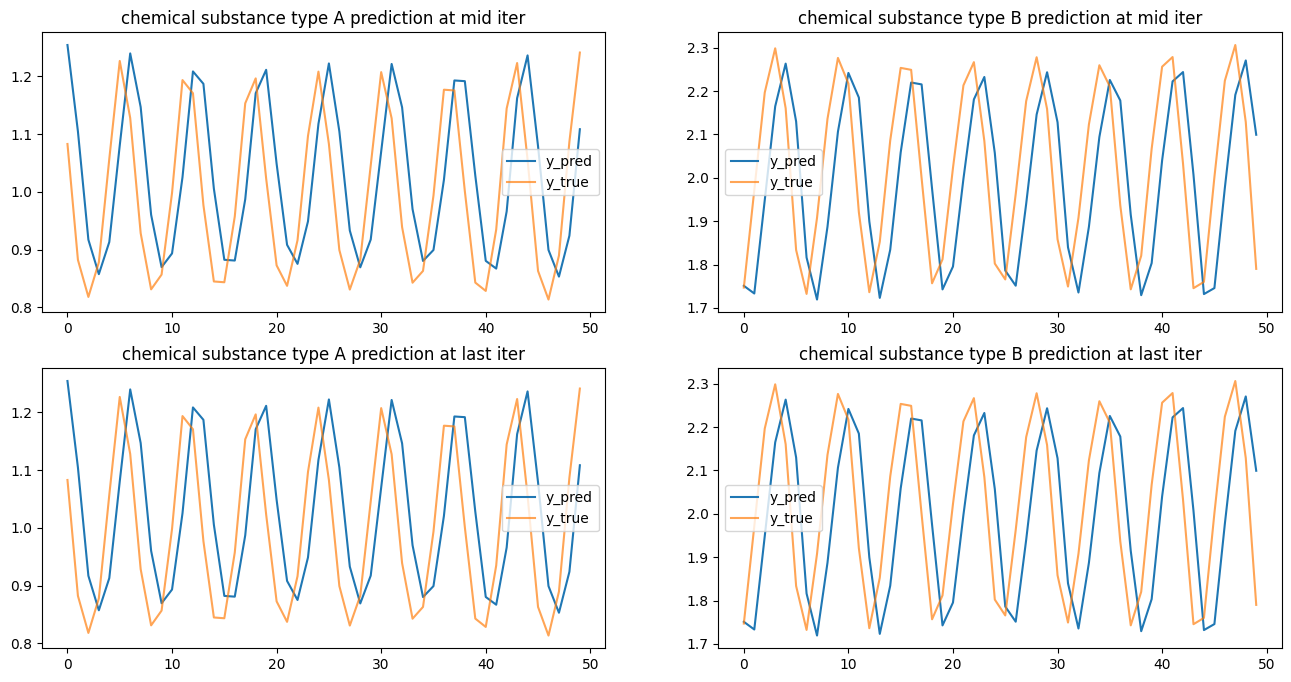

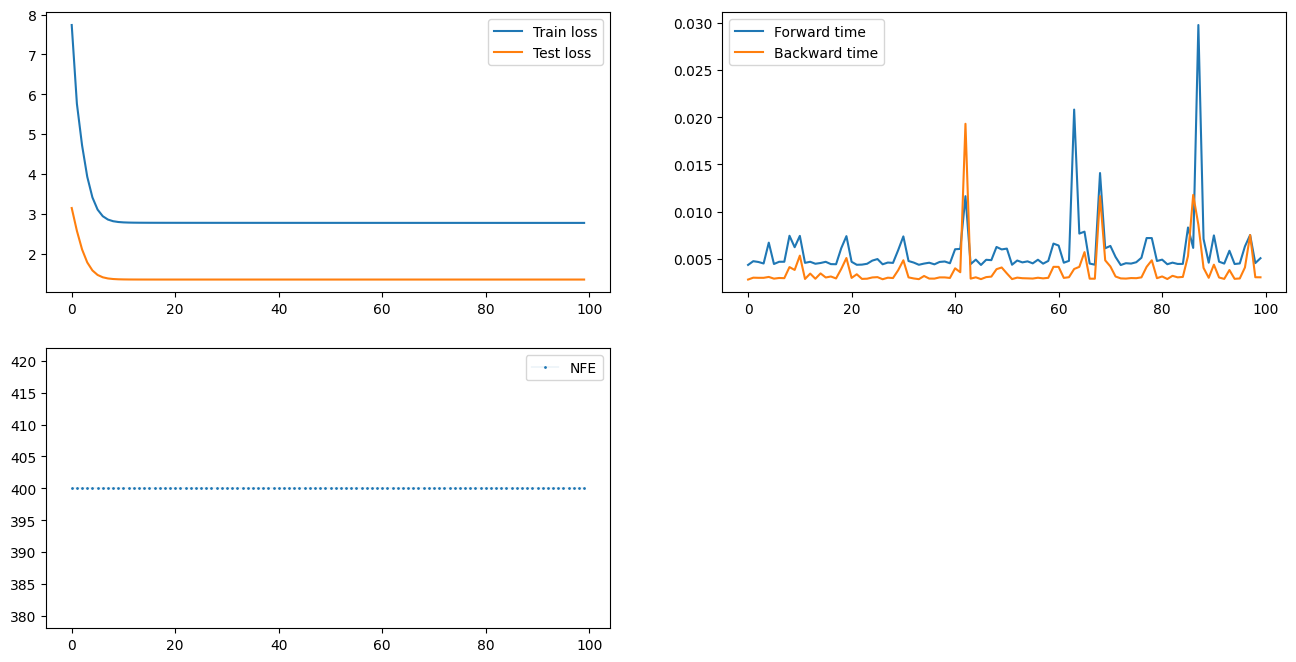

**num = 4**



```
Final Model with hidden dim = 4
Mean Squared Error of Training:  0.02841
Mean Squared Error of Test:  0.02724 

('0.weight', Parameter containing:
tensor([[ 4.7331e-01, -4.3697e-25,  1.5976e-02,  4.9366e-01]],
       dtype=torch.float64, requires_grad=True))
('0.bias', Parameter containing:
tensor([ 2.8597e-01, -2.2209e-24,  2.6736e-01, -5.4304e-03],
       dtype=torch.float64, requires_grad=True))
('1.odefunc.gnn.0.weight', Parameter containing:
tensor([[ 0.7092,  0.4931,  0.2402,  0.7691],
        [-0.3922, -0.0896, -0.4971, -0.0152],
        [ 0.2872, -0.1703,  0.3026,  0.1915],
        [ 0.9379,  0.2656,  0.6788,  0.3807]], dtype=torch.float64,
       requires_grad=True))
('1.odefunc.gnn.0.bias', Parameter containing:
tensor([ 0.3328,  0.0491, -0.1284,  0.1627], dtype=torch.float64,
       requires_grad=True))
('1.odefunc.gnn.1.weight', Parameter containing:
tensor([[-0.0831, -0.1879, -0.3031,  0.2556],
        [-0.2873, -0.3138, -0.2107, -0.3481],
        [ 0.1567, -0.5809,  0.3630, -0.4618],
        [ 0.4773, -0.0031, -0.2300,  0.2300]], dtype=torch.float64,
       requires_grad=True))
('1.odefunc.gnn.1.bias', Parameter containing:
tensor([ 0.0800,  0.3915,  0.0390, -0.1987], dtype=torch.float64,
       requires_grad=True))
('2.weight', Parameter containing:
tensor([[ 0.6684],
        [-0.7686],
        [-0.9047],
        [-0.0980]], dtype=torch.float64, requires_grad=True))
('2.bias', Parameter containing:
tensor([-0.7317], dtype=torch.float64, requires_grad=True))
```



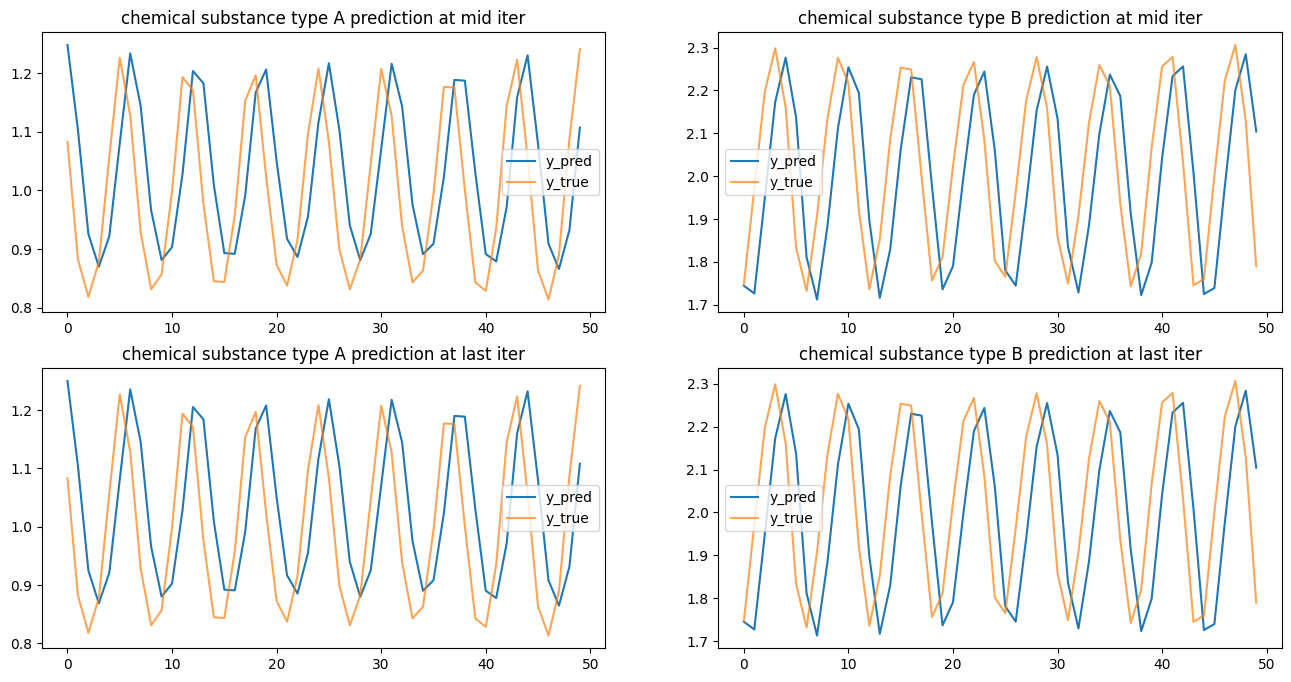

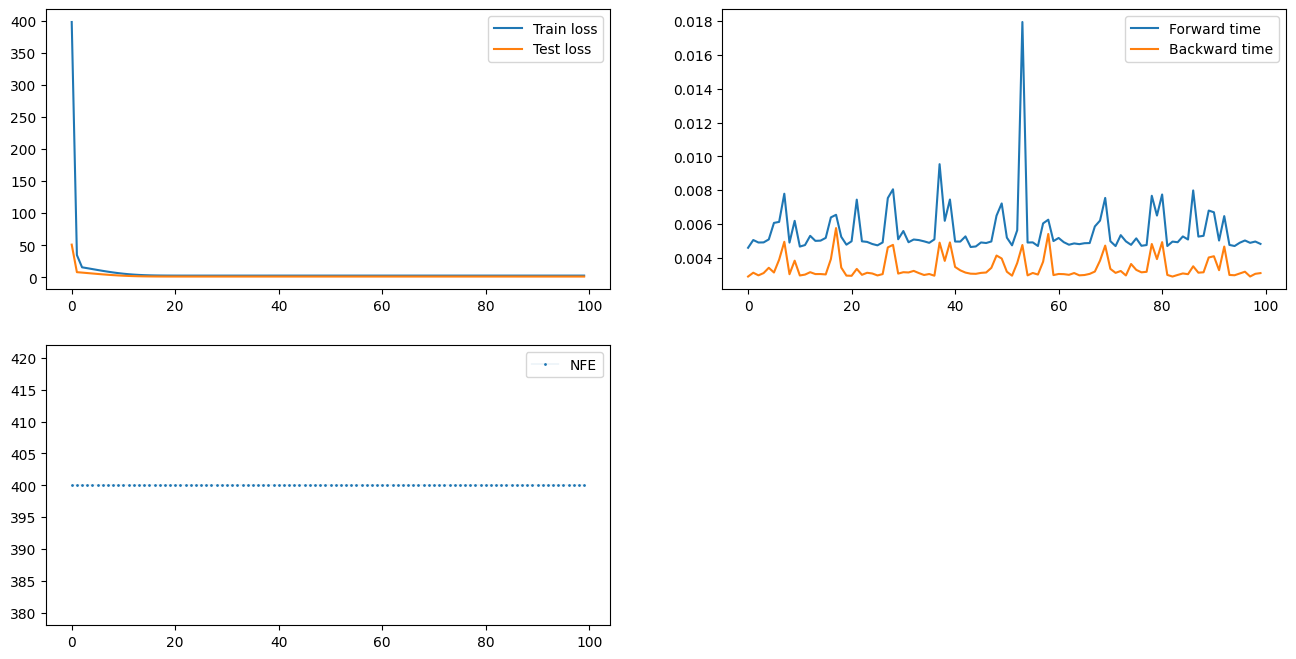

**num = 8**



```
Final Model with hidden dim = 4
Mean Squared Error of Training:  0.02636
Mean Squared Error of Test:  0.02484 

('0.weight', Parameter containing:
tensor([[ 2.5651e-01, -3.3909e-05,  3.5348e-01,  2.3528e-01,  4.8474e-01,
         -4.5493e-09, -3.4318e-02, -2.8313e-12]], dtype=torch.float64,
       requires_grad=True))
('0.bias', Parameter containing:
tensor([-1.3699e-01, -2.1749e-08,  2.8675e-01, -4.2205e-01,  1.6567e-01,
        -1.1677e-15,  1.0856e-01, -9.5541e-15], dtype=torch.float64,
       requires_grad=True))
('1.odefunc.gnn.0.weight', Parameter containing:
tensor([[ 0.4213,  0.0829, -0.0807,  0.4533, -0.1865,  0.1524, -0.2192,  0.0328],
        [ 0.2474, -0.1305,  0.1451,  0.0236,  0.1715,  0.0307,  0.1120,  0.0402],
        [ 0.3661, -0.0409, -0.0878,  0.1935, -0.1911,  0.0429, -0.1515,  0.0739],
        [-0.3477, -0.0166,  0.0712, -0.2707,  0.0774, -0.2600,  0.2663, -0.0235],
        [ 0.4263, -0.0708, -0.0639,  0.3704, -0.0880,  0.3405, -0.0585, -0.0262],
        [ 0.0781, -0.0100, -0.0061,  0.1076, -0.0110,  0.0128, -0.0122,  0.0023],
        [ 0.1700, -0.0629, -0.0209, -0.0331, -0.0605,  0.0492, -0.0015, -0.0070],
        [ 0.0862,  0.0249,  0.0776, -0.2071, -0.0016, -0.1024,  0.0443,  0.0289]],
       dtype=torch.float64, requires_grad=True))
('1.odefunc.gnn.0.bias', Parameter containing:
tensor([ 0.1093, -0.0889,  0.1395, -0.1893, -0.1378, -0.1944,  0.2495, -0.0227],
       dtype=torch.float64, requires_grad=True))
('1.odefunc.gnn.1.weight', Parameter containing:
tensor([[ 0.3794, -0.2178, -0.2802, -0.3145, -0.1834,  0.0943,  0.0781,  0.3305],
        [-0.1748, -0.1957,  0.1653, -0.1410,  0.2034, -0.0334,  0.1751, -0.2567],
        [-0.2041,  0.0781,  0.0259, -0.0565,  0.1595,  0.1434, -0.2042, -0.2038],
        [ 0.3567, -0.0622, -0.0740, -0.3721, -0.1544,  0.0556, -0.0803, -0.2102],
        [-0.0277, -0.2027, -0.2880, -0.1502, -0.3254, -0.0485,  0.3132,  0.0340],
        [ 0.1370, -0.2586, -0.1819, -0.1442,  0.0847, -0.2002, -0.1701, -0.1739],
        [-0.0341, -0.1261, -0.0640, -0.1967, -0.2692, -0.0587, -0.0828, -0.2904],
        [ 0.2945, -0.0460,  0.2818,  0.1013, -0.2833,  0.1632, -0.0975, -0.1227]],
       dtype=torch.float64, requires_grad=True))
('1.odefunc.gnn.1.bias', Parameter containing:
tensor([-0.3007, -0.3156,  0.0731, -0.0630,  0.1140, -0.1587,  0.2491, -0.2599],
       dtype=torch.float64, requires_grad=True))
('2.weight', Parameter containing:
tensor([[ 0.9844],
        [ 0.1970],
        [ 0.1897],
        [-0.8990],
        [ 0.5755],
        [-0.0634],
        [-0.3589],
        [ 0.8338]], dtype=torch.float64, requires_grad=True))
('2.bias', Parameter containing:
tensor([0.2057], dtype=torch.float64, requires_grad=True))
```



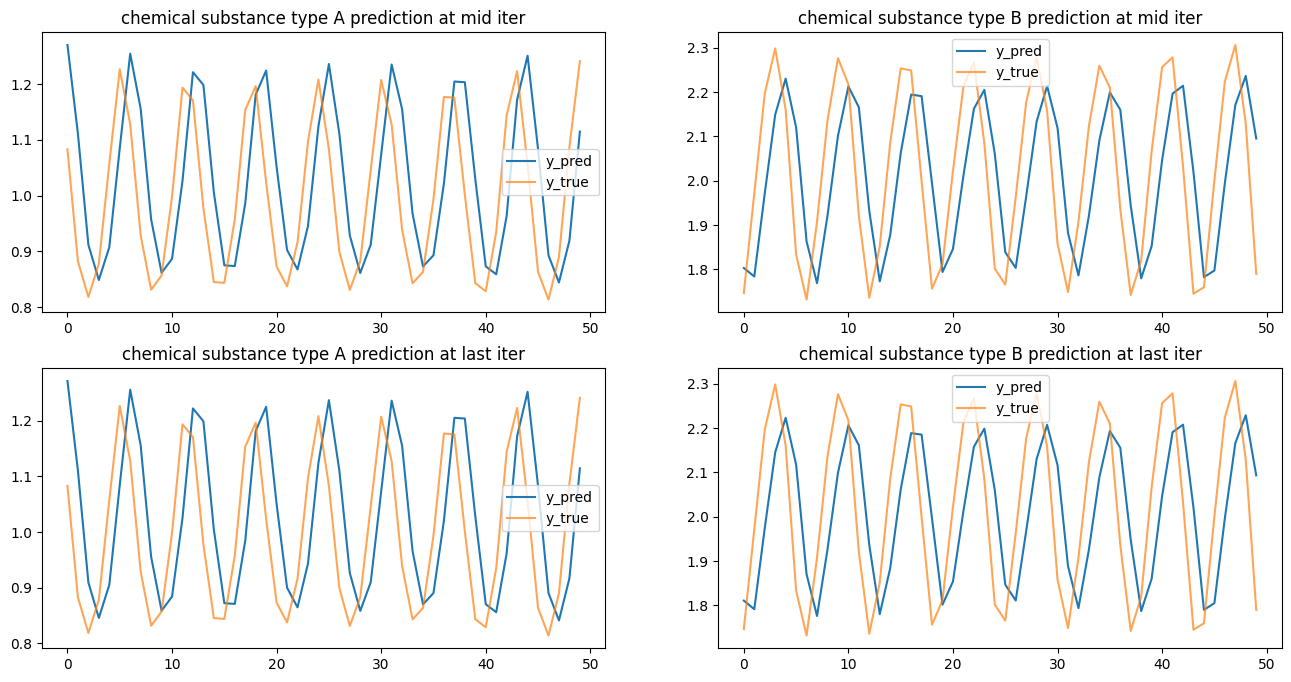

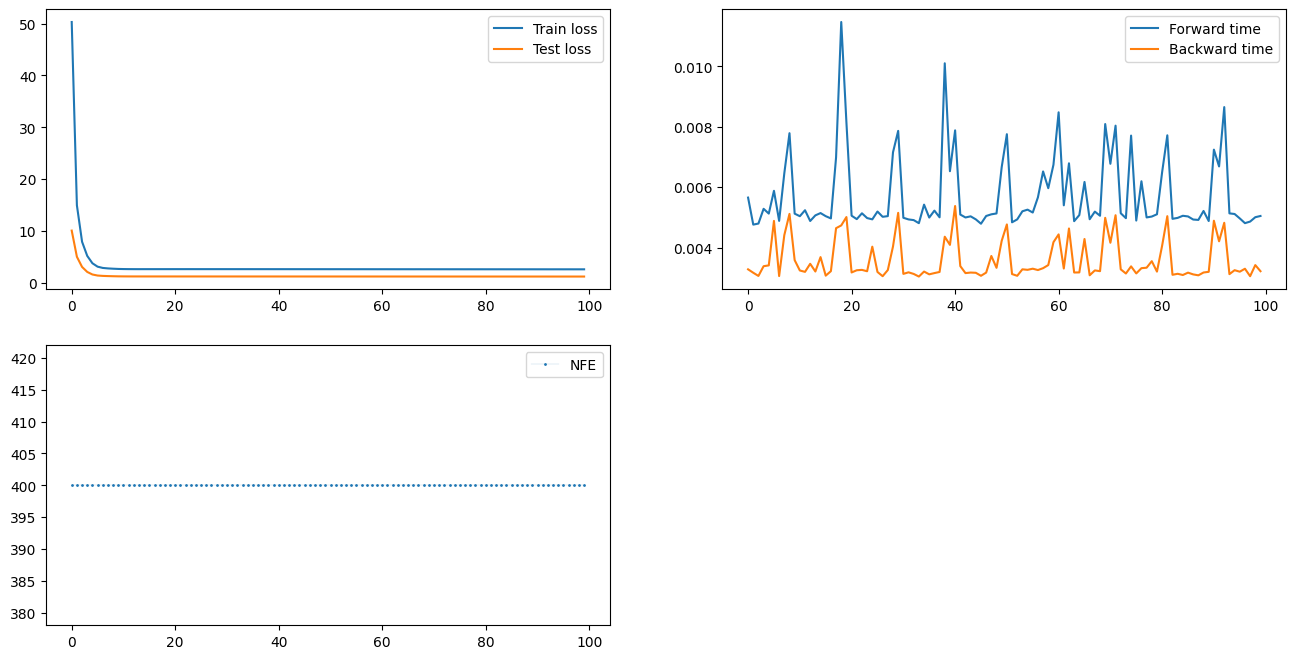

**num = 16** \\


```
Final Model with hidden dim = 16 with 1000 iteration
Mean Squared Error of Training:  0.026099999999999998
Mean Squared Error of Test:  0.02456 
```

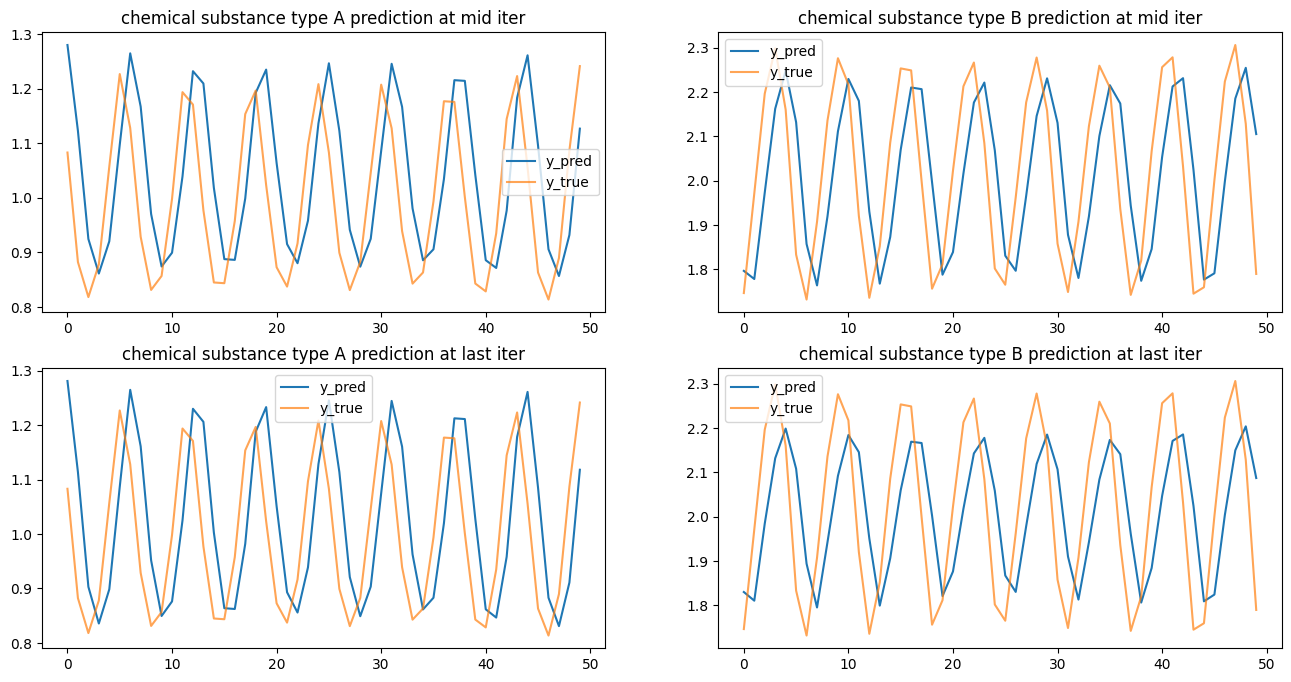

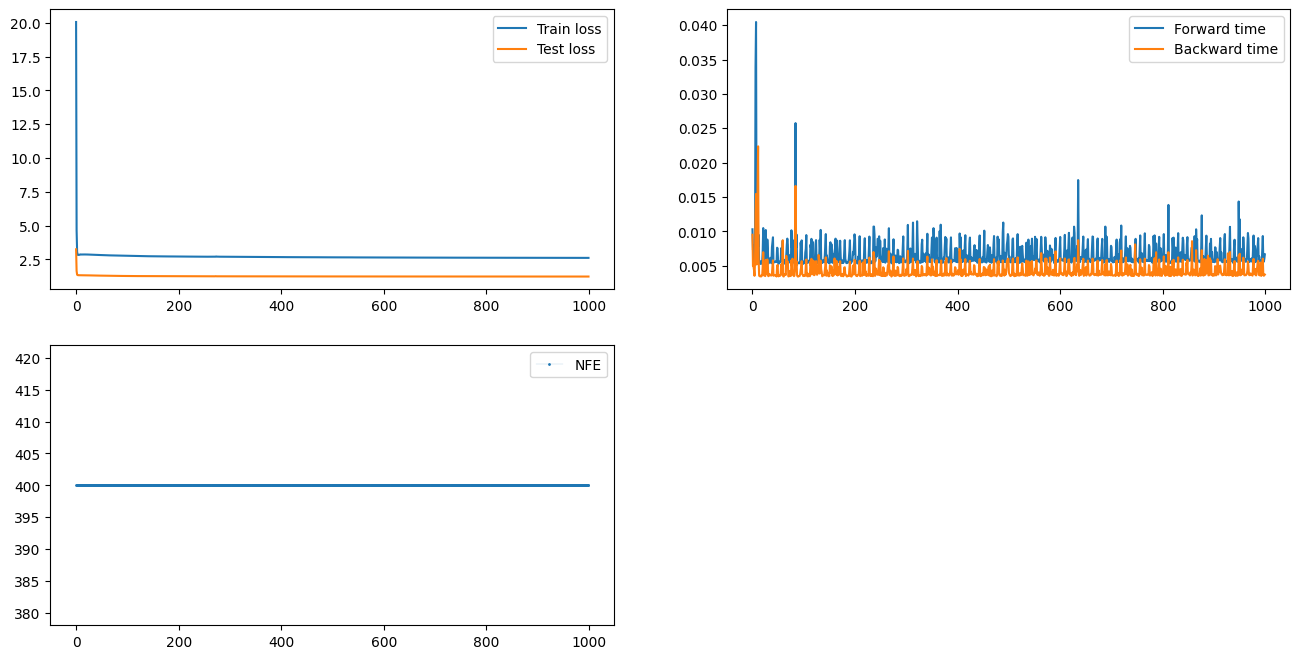

## GCN

We are interested in observing the training behavior of regular GCNs of different layer depths. Below is a training loop
that will collect metrics for GCNs of layers `1, 3, 5, 7`

In [ ]:
loggers = []

for n_layers in range(2, 9, 2):
    
    gcn = GCN(num_layers=n_layers, g=g, in_feats=1, hidden_feats=64, out_feats=1, activation=F.relu, dropout=0.9).to(device)
    opt = torch.optim.Adam(gcn.parameters(), lr=1e-3, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()
    num_grad_steps = 3000
    
    gcn_logger = PerformanceContainer(data={'train_loss':[], 'train_accuracy':[],
                                    'test_loss':[], 'test_accuracy':[],
                                    'forward_time':[], 'backward_time':[]}
                                      )
    
    for i in range(num_grad_steps): # looping over epochs  
        start_time = time.time()
        outputs = gcn(X)
        f_time = time.time() - start_time

        y_pred = outputs

        loss = criterion(y_pred[train_mask], Y[train_mask])
        opt.zero_grad()

        start_time = time.time()
        loss.backward()
        b_time = time.time() - start_time
    
        opt.step()
        num_grad_steps += 1

        with torch.no_grad():
            gcn.eval()
            outputs = gcn(X)
            y_pred = outputs
            
            train_loss = loss.item()
            train_acc = accuracy(y_pred[train_mask], Y[train_mask]).item()
            test_acc = accuracy(y_pred[test_mask], Y[test_mask]).item()
            test_loss = criterion(y_pred[test_mask], Y[test_mask]).item()

            gcn_logger.deep_update(gcn_logger.data, dict(train_loss=[train_loss], train_accuracy=[train_acc],
                                   test_loss=[test_loss], test_accuracy=[test_acc], forward_time=[f_time],
                                   backward_time=[b_time]))
            
    loggers.append((gcn_logger, n_layers))

## Comparison plots

GCDEs are shown to be as performing as GDEs, while being deeper and not requiring selection of number of layers. They are observed to converge faster; the high degree of noise present is due to the aggressive dropout setting, used to exploit the increased depth of GCDEs.

In [ ]:
mean_nfe = int(np.array(logger.data['nfe']).mean())
layer_range = range(2, 9, 2)

plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
plt.plot(logger.data['train_loss'])
for logger_gcn, l in loggers: plt.plot(logger_gcn.data['train_loss'])
plt.title('Training loss')
plt.legend([f'GCDE{mean_nfe}'] + [f'GCN{i}' for i in layer_range])
plt.ylim(0,2)

plt.subplot(2,2,2)
plt.plot(logger.data['test_loss'])
for logger_gcn, l in loggers: plt.plot(logger_gcn.data['test_loss'])
plt.title('Test loss')
plt.legend([f'GCDE{mean_nfe}'] + [f'GCN{i}' for i in layer_range])
plt.ylim(0,3)

plt.subplot(2,2,3)
plt.plot(logger.data['train_accuracy'])
for logger_gcn, l in loggers: plt.plot(logger_gcn.data['train_accuracy'])
plt.title('Train accuracy')
plt.legend([f'GCDE{mean_nfe}'] + [f'GCN{i}' for i in layer_range])

plt.subplot(2,2,4)
plt.plot(logger.data['test_accuracy'])
for logger_gcn, l in loggers: plt.plot(logger_gcn.data['test_accuracy'])
plt.title('Test accuracy')
plt.legend([f'GCDE{mean_nfe}'] + [f'GCN{i}' for i in layer_range]);

### Time complexity

The plots below show how forward time for GCDEs is roughly 6 times that of GCN2

In [ ]:
ftime = logger.data['forward_time']
btime = logger.data['backward_time']

In [ ]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(ftime)
for logger_gcn, l in loggers: plt.plot(logger_gcn.data['forward_time'])
plt.title('Forward time (s)')
plt.legend(['GCDE'] + [f'GCN{i}' for i in layer_range])
plt.ylim(0, 0.006)

plt.subplot(1,2,2)
plt.plot(btime)
for logger_gcn, l in loggers: plt.plot(logger_gcn.data['backward_time'])
plt.title('Backward time (s)')
plt.legend(['GCDE'] + [f'GCN{i}' for i in layer_range]);